# ASTR 596: FDS Homework 6: Hunting for Exoplanets


### If you are watching Star Trek: Picard, then you might wonder about the "Admonition" - a warning/message left in an octuple planet system about past synthetic life in the Galaxy.

### [Ethan Siegel's Starts With a Bang blog has even covered it](https://www.forbes.com/sites/startswithabang/2020/03/19/is-star-trek-picards-hypothesized-octuple-star-system-really-possible/)

### The Kepler satellite has discovered many multi-planet systems. You can download artwork for some of them even at the [Exoplanet Travel Bureau](https://exoplanets.nasa.gov/alien-worlds/exoplanet-travel-bureau/)

<img src="../Users/patrickaleo/ast596_2020_Spring/homework/06/Kepler-186f_small.jpg">


### But is there a system with 8 planets??? In fact, there may be at least one - [Kepler 90](https://www.nytimes.com/2017/12/14/science/eight-planets-star-system.html). This along with most other Kepler planets, were not discovered through radial velocity measurements like our example in class (i.e. that nice parameteric model doesn't apply), but were rather discovered through transits - dips in the light of the star as the planet moves around it.


<img src="../Users/patrickaleo/ast596_2020_Spring/homework/06/Transiting-Exoplanet-Light-Curve.gif">

### You get to find 3 exoplanets in the Kepler-90 system with `gatspy`. 


### To get the Kepler data, you'll need the `lightkurve` package

> `conda install lightkurve`

### I've included some code to get the light curve, clean it and remove the NaNs, but not outliers (you can judge the wisdom of outlier removal when you are hunting for planets).


<hr>

#### Hints:

* `gatspy` has a `predict` method that you can use to get a model light curve for some period (you should need no more 3-5 terms). You might find it easier to remove the signal of each planet as you find it and work with the residual light curve to find the next.

* `lightkurve` has a bunch of useful [tutorials](https://docs.lightkurve.org/index.html)

* [The Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/index.html) might be of help

<hr>

# Happy (planet) hunting!

Ok! I'll try.

In [1]:
%matplotlib inline
import lightkurve as lk
import gatspy
import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u

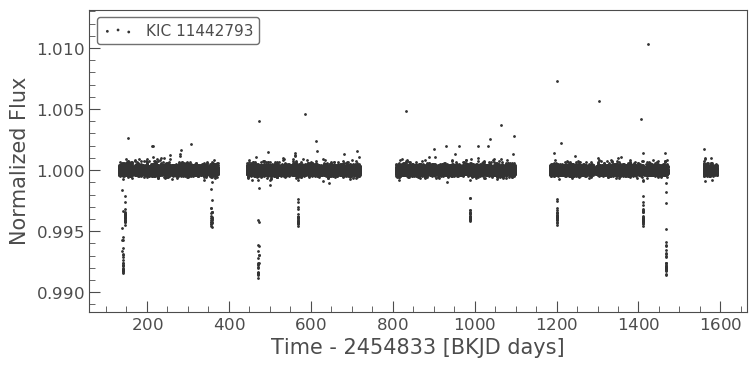

In [2]:
lcfs = lk.search_lightcurvefile('Kepler-90', mission='Kepler').download_all()

def squelch_rednoise(lc):
    corrected_lc = lc.normalize().flatten(window_length=51)
    return corrected_lc

stitched_lc = lcfs.PDCSAP_FLUX.stitch(corrector_func=squelch_rednoise)
clc = stitched_lc.remove_nans()

clc.scatter();

Although not really helpful in planet-hunting, it's good to look at a piece of my data to get a sense of it:

In [8]:
tpf_q7 = lk.search_targetpixelfile('Kepler-90', mission='Kepler', quarter='7').download()

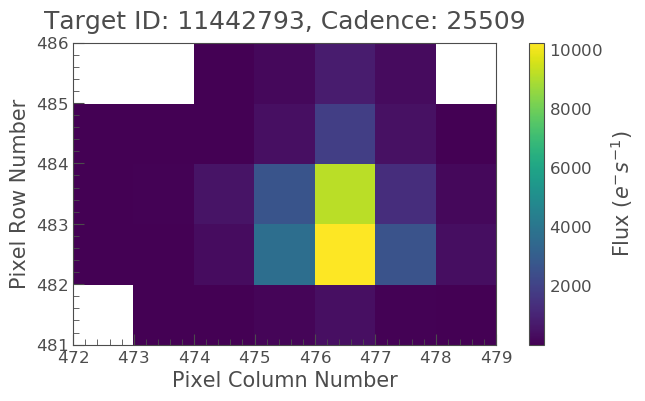

In [9]:
tpf_q7.plot();

Here's what the unnormalized lc for quarter 7 looks like:

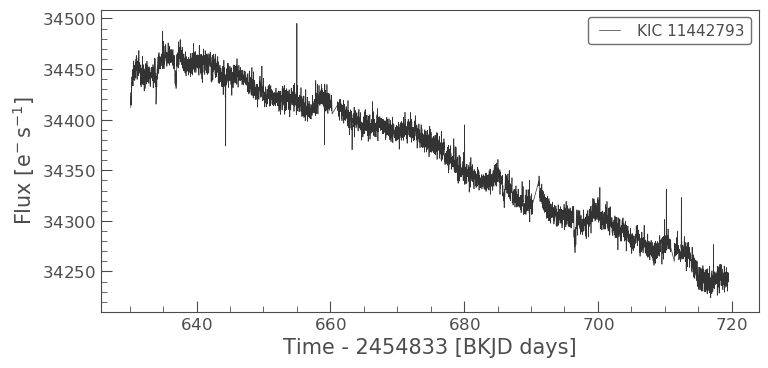

In [16]:
lc_q7 = tpf.to_lightcurve(aperture_mask=tpf.pipeline_mask)
lc_q7.plot()

And here's the normalized version over all quarters, but is unclean.

/Users/patrickaleo/miniconda3/envs/fds/lib/python3.6/site-packages/lightkurve/collections.py:238: LightkurveWarning: Plotting a `LightCurveFileCollection` which contains both SAP and PDCSAP_FLUX. Plotting PDCSAP_FLUX. You can remove this warning by using `LightCurveFileCollection.PDCSAP_FLUX.plot()`.
  LightkurveWarning)


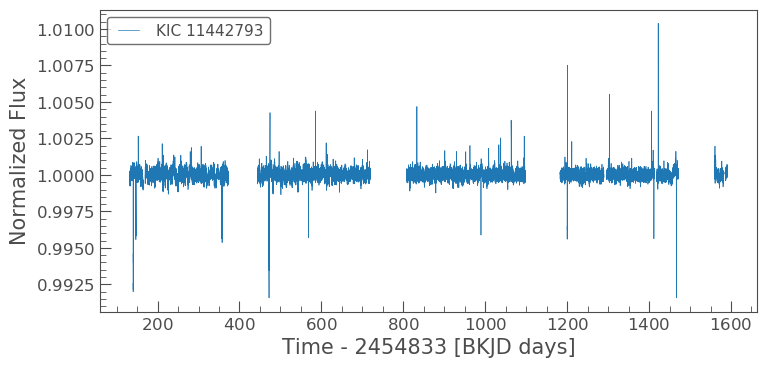

In [17]:
lcfs.plot()

I definitely like the clean version, so let's use that...

## Exo-1

In [18]:
flat, trend = clc.flatten(return_trend=True)

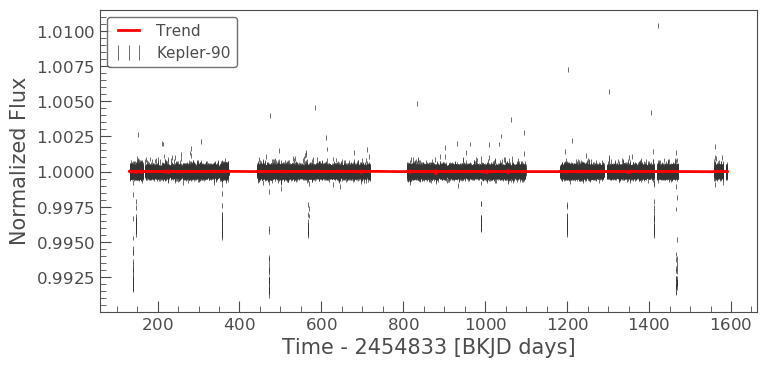

In [19]:
ax = clc.errorbar(label="Kepler-90")                   # plot() returns a matplotlib axes ...
trend.plot(ax=ax, color='red', lw=2, label='Trend');  # which we can pass to the next plot() to use the same axes

`period` contains 2837710 points.Periodogram is likely to be large, and slow to evaluate. Consider setting `frequency_factor` to a higher value.


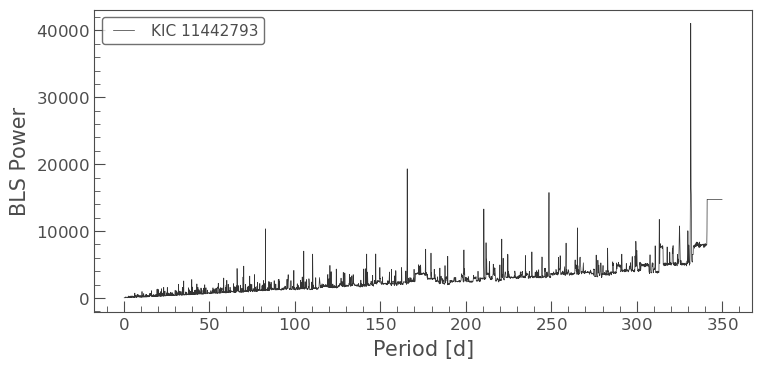

In [20]:
periodogram = flat.to_periodogram(method="bls", period=np.arange(0.3, 350, 0.1))
periodogram.plot();

This BoxedLeastSquares power plot is very obviously peaked around 330 ish, and the signal is so above the noise it looks to be real. But let's find the exact period, which should be the period of this mystery exo-planet!

In [21]:
best_fit_period = periodogram.period_at_max_power
print('Best fit period: {:.3f}'.format(best_fit_period))

Best fit period: 331.600 d


Text(0.5, 1.0, 'Exo-Planet 1')

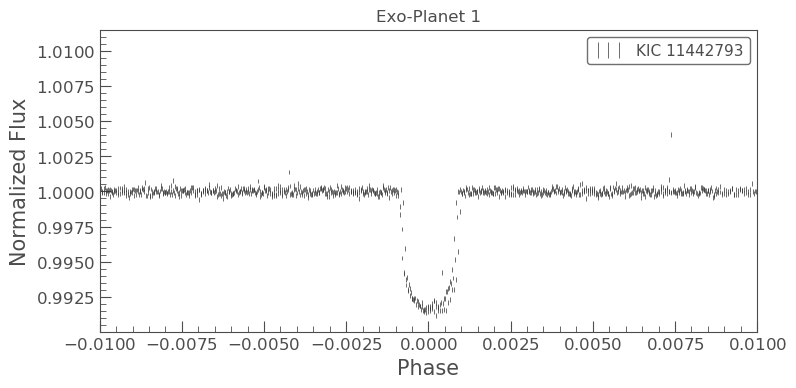

In [23]:
ax = flat.fold(period=best_fit_period, t0=periodogram.transit_time_at_max_power).errorbar();
ax.set_xlim(-0.01, 0.01)
ax.set_title('Exo-Planet 1')

Look at this exo-planet!!! It appears to be Kepler-90h. We can see in the folded light curve the transit of this exo-planet across the face of its parent star, dimming it almost by 1%! This was relatively easy to find because it's quite big...

## Exo-2

Now it gets a bit tricky, as multiples of Exo-1's period shows up in the data quite a bit. Leaving them in there can affect how we find other real period signals from the other exoplanets. So we will identify some multiples, and mask these out so that we can remake a periodogram without these signals...

`period` contains 2837710 points.Periodogram is likely to be large, and slow to evaluate. Consider setting `frequency_factor` to a higher value.
/Users/patrickaleo/miniconda3/envs/fds/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':


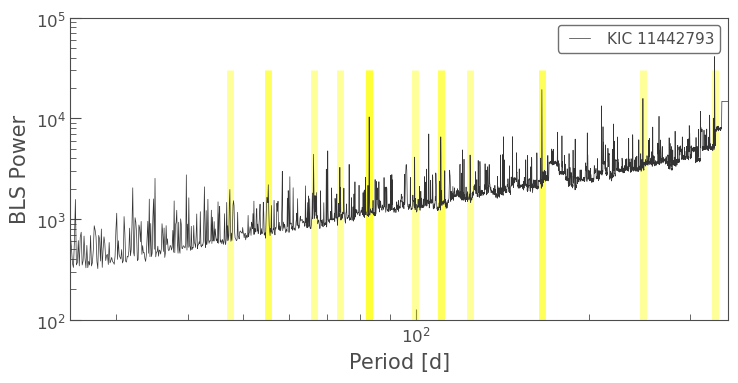

In [143]:
periodogram = flat.to_periodogram(method="bls", period=np.arange(.3, 350, 0.1))
ax = periodogram.plot()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(25, 350)
ax.set_ylim(10e1, 10e4)

best_fit_period = periodogram.period_at_max_power
period_muls = [best_fit_period.value/j for j in range(0,8)]
period_muls += [best_fit_period.value/j*2/3 for j in range(2,4)]
period_muls += [best_fit_period.value/j*1/2 for j in range(2,4)]
period_muls += [best_fit_period.value/j*3/2 for j in range(2,7)]
ax.vlines(period_muls, 0, 3e4, lw=5, color='yellow', alpha=0.4)

As we can see, some of these multiples are also peaks in the (log-log) periodogram, which means if we chose these peaks, we'd find some multiple of Exo-1's period. To start the masking process, I extract our current periodogram data.

In [86]:
t= periodogram.to_table()
print(t)

      frequency             period             power       
        1 / d                 d                            
--------------------- ------------------ ------------------
   3.3333333333333335                0.3 12.480973957137746
                  2.5                0.4  7.719018698919282
                  2.0                0.5 18.176096240254516
   1.6666666666666665 0.6000000000000001  56.65238990997005
   1.4285714285714282 0.7000000000000002  46.29361784340264
   1.2499999999999996 0.8000000000000003 23.836512679875806
    1.111111111111111 0.9000000000000001 17.737527202866566
   0.9999999999999998 1.0000000000000002 15.370246021311857
   0.9090909090909088 1.1000000000000003  32.10186354557788
    0.833333333333333 1.2000000000000004 100.55659319870642
                  ...                ...                ...
 0.002865329512893982  349.0000000000001 14740.038100409885
 0.002864508736751646 349.10000000000014 14740.038100409885
0.0028636884306987393  349.2000000000001

In [125]:
for k in range(1,8):
    print(t[t['period'] == periods[k]])

     frequency             period             power      
       1 / d                 d                           
-------------------- ------------------ -----------------
0.003015681544028949 331.60000000000014 41066.26534177012
     frequency             period             power       
       1 / d                 d                            
-------------------- ------------------ ------------------
0.006031363088057898 165.80000000000007 19304.025097458332
frequency period power
  1 / d     d         
--------- ------ -----
frequency period power
  1 / d     d         
--------- ------ -----
frequency period power
  1 / d     d         
--------- ------ -----
frequency period power
  1 / d     d         
--------- ------ -----
frequency period power
  1 / d     d         
--------- ------ -----


I'm not sure why these didn't all show up, but these should be the power at each multple of Exo-1's period. The Table data values (index) is separated every 0.1 day...

In [87]:
period = t['period']
power = t['power']
freq = t['frequency']

In [24]:
mask = np.ones_like(clc.time)
ttmp = periodogram.transit_time_at_max_power 
tran_t = [ttmp + best_fit_period.value*b for b in range(0,10)]

#create our masks
# setting the mask to the median doesn't change the results, so
# excise the data out algother by setting it to 0
#choose index of +/- 10 (or 1 day in period) so that little data is removed
for k in tran_t:
    indx = (np.abs(clc.time - k)).argmin()
    for l in np.arange(indx-10, indx+10, 1): 
        if l > 0 and l < len(mask):
            #mask[l] = np.median(clc.flux) #= to 0.999998926975368
            mask[l] = 0

Now we create a new periodogram with our Exo-1 period multiples removed/masked out, and we repeat process from above to find highest power and associated period, which should be Exo-2's period!

`period` contains 2836836 points.Periodogram is likely to be large, and slow to evaluate. Consider setting `frequency_factor` to a higher value.


Our Exo-2 period is 210.60000000000008 d


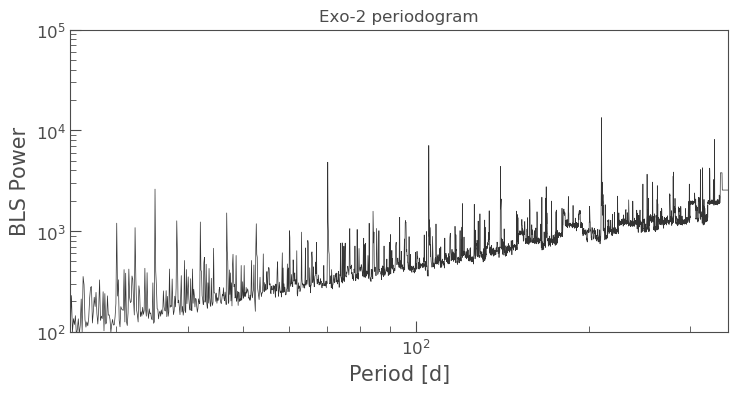

In [28]:
mask = mask.astype(bool)
clc_p2 = lk.lightcurve.KeplerLightCurve(clc.time[mask], clc.flux[mask], clc.flux_err[mask])
flat_p2, trend_p2 = clc_p2.flatten(return_trend=True)

periodogram_p2 = flat_p2.to_periodogram(method="bls", period=np.arange(.3, 350, 0.1))
ax = periodogram_p2.plot()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(25, 350)
ax.set_ylim(10e1, 10e4)
ax.set_title('Exo-2 periodogram')

best_fit_period_p2 = periodogram_p2.period_at_max_power
print('Our Exo-2 period is', best_fit_period_p2)

Fold...

(-0.01, 0.01)

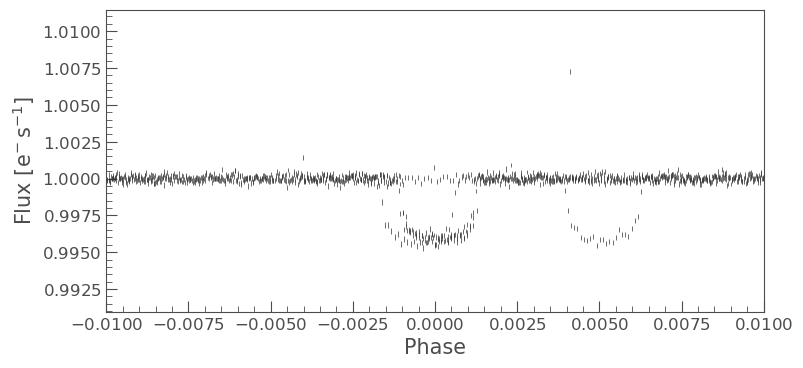

In [257]:
ax = flat_p2.fold(period=best_fit_period_p2, t0=periodogram_p2.transit_time_at_max_power).errorbar();
ax.set_xlim(-0.01, 0.01)

The phase may not be the cleanest, but we can clearly see another transit at this period, at a flux removal of 0.5%. This must be real and is in-fact Kepler-90g! :D

Now repeat masking process and make new periodogram for Exo-3...

In [29]:
mask = np.ones_like(clc_p2.time)
ttmp = periodogram_p2.transit_time_at_max_power 
tran_t = [ttmp + best_fit_period_p2.value*b for b in range(0,10)]

for k in tran_t:
    indx = (np.abs(clc_p2.time - k)).argmin()
    for l in np.arange(indx-30, indx+30, 1):
        if l > 0 and l < len(mask):
            mask[l] = 0

`period` contains 2833968 points.Periodogram is likely to be large, and slow to evaluate. Consider setting `frequency_factor` to a higher value.


Exo 3 period is... 248.70000000000007 d


/Users/patrickaleo/miniconda3/envs/fds/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app


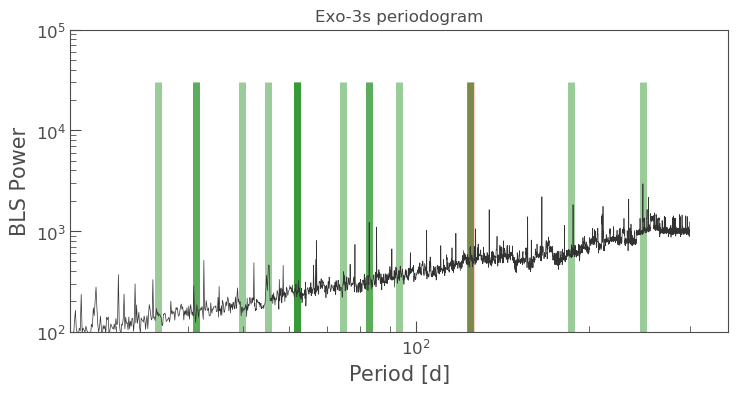

In [33]:
mask = mask.astype(bool)
clc_p3 = lk.lightcurve.KeplerLightCurve(clc_p2.time[mask], clc_p2.flux[mask], clc_p2.flux_err[mask])
flat_p3, trend_p3 = clc_p3.flatten(return_trend=True)

periodogram_p3 = flat_p3.to_periodogram(method="bls", period=np.arange(.3, 300, 0.1))
ax = periodogram_p3.plot()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(25, 350)
ax.set_ylim(10e1, 10e4)
ax.set_title('Exo-3s periodogram')

best_fit_period_p3 = periodogram_p3.period_at_max_power
print('Exo 3 period is...', best_fit_period_p3)
period_muls_p3 = [best_fit_period_p3.value/j for j in range(0,8)]
period_muls_p3 += [best_fit_period_p3.value/j*2/3 for j in range(2,4)]
period_muls_p3 += [best_fit_period_p3.value/j*1/2 for j in range(2,4)]
period_muls_p3 += [best_fit_period_p3.value/j*3/2 for j in range(2,7)]
ax.vlines(period_muls_p3, 0, 3e4, lw=5, color='green', alpha=0.4)
ax.vlines(124.9, 0, 3e4, lw=5, color='red', alpha=0.2) #this is known period of planet Kepler 90-f (my Exo-3)

Here, all multiples of Exo-3's (really Kepler 90-f) period is marked in green, while its true period is marked in red (which when overlapped with green makes that brown ish color). We can see that one of the period multiples is the true period of $\sim 124$ d.

In [274]:
print(period_muls_p3)

[inf, 248.70000000000007, 124.35000000000004, 82.90000000000002, 62.17500000000002, 49.740000000000016, 41.45000000000001, 35.52857142857144, 82.90000000000002, 55.26666666666668, 62.17500000000002, 41.45000000000001, 186.52500000000006, 124.35000000000002, 93.26250000000003, 74.61000000000003, 62.17500000000001]


Text(0.5, 1.0, 'folded lc for true period 124 d')

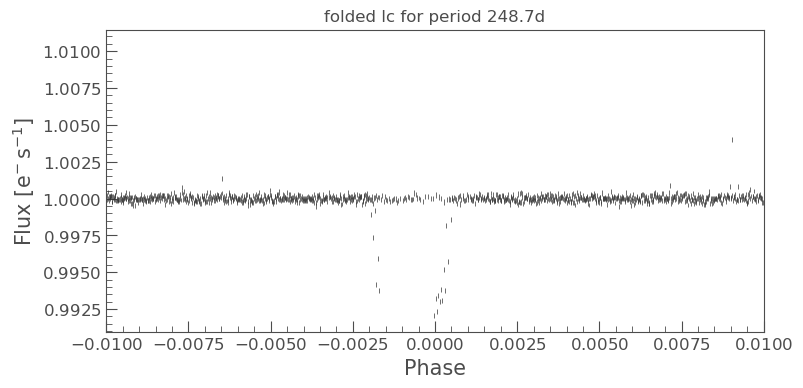

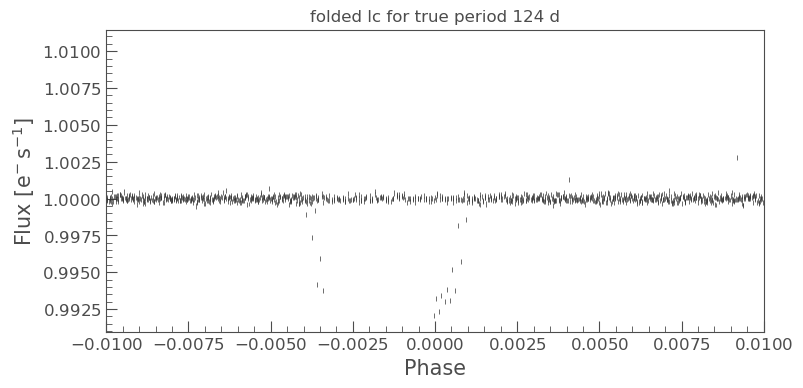

In [34]:
ax1 = flat_p3.fold(period=best_fit_period_p3, t0=periodogram_p3.transit_time_at_max_power).errorbar();
ax1.set_xlim(-0.01, 0.01)
ax1.set_title('folded lc for period 248.7d')

ax2 = flat_p3.fold(period=124.35, t0=periodogram_p3.transit_time_at_max_power).errorbar();
ax2.set_xlim(-0.01, 0.01)
ax2.set_title('folded lc for true period 124 d')

We can see that the planet's period is really 124.35d $\approx 124.9$d, which is a multiple of the original period we found at 248.7 d (just multiplied by 2). We can see that the transit is wider on the same scale and to a similar depth, which leads me to believe (and b/c I know $a priori$) that Exo-3's period is really $\approx 124$d!

It makes sense that the two biggest exo-planets were the ones found first, because they would have the largest occlusion of their host star.

If I had more time, I'd confirm these periods I found are true by making a model transit and comparing to the real light curve. But overall, I'm satisfied with my three exoplanets found at 331d, 210d, and 124d.

For comparison of known data, see https://en.wikipedia.org/wiki/Kepler-90 and the NASA exoplanet archive.

In [248]:
print(np.median(clc_p2.flux))

0.999998926975368
